In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# from snmfem.experiments import load_samples, print_results, load_data, run_experiment
from esmpy.measures import KL, trace_xtLx
from esmpy.estimators.updates import multiplicative_step_h, multiplicative_step_w, multiplicative_step_hq
from esmpy.conf import log_shift, dicotomy_tol, sigmaL
from esmpy.utils import create_laplacian_matrix
from esmpy.estimators.smooth_nmf import diff_surrogate
from esmpy.estimators import SmoothNMF
from copy import deepcopy


In [6]:
def create_toy_problem(l = 25, k = 3, p = 100, c = 10, n_poisson=200, force_simplex=True):

    A = np.random.rand(k,p)
    if force_simplex:
        A = A/np.sum(A, axis=0, keepdims=True)
    
    G = np.random.rand(l,c)
    P = np.random.rand(c,k)
    GP = G @ P

    X = GP @ A

    Xdot = 1/n_poisson * np.random.poisson(n_poisson * X)

    return G, P, A, X, Xdot

In [7]:
def one_experiment(X, W0, H0, experiment_param, algo_param, global_param):
    est = SmoothNMF(**algo_param, **experiment_param, **global_param)
    W = est.fit_transform(X, W=W0, H=H0)
    H = est.H_
    losses = est.get_losses()
    loss = losses["full_loss"].copy()
    final_loss = loss[-1]
    gamma = losses["gamma"].copy()
    return loss, final_loss, W.copy(), H.copy(), gamma

In [8]:
# global parameters
global_param = dict()
global_param["l2"] = False
global_param["verbose"]= 0
global_param["tol"] = 0
global_param["max_iter"] = 1000
global_param["dicotomy_tol"] = dicotomy_tol
global_param["debug"] = False
global_param["log_shift"] = log_shift
global_param["eval_print"] = 10
global_param["hspy_comp"] = False

In [9]:

shape_2d = [10, 15]
k = 5
n_poisson = 200
G, P, A, Xtrue, X = create_toy_problem(p = shape_2d[0]*shape_2d[1], k=k, n_poisson=n_poisson)

true_D = G @ P
true_H = A

# X = Xtrue
L = create_laplacian_matrix(*shape_2d)
lambda_L = 20

W0 = np.random.rand(*true_D.shape)
H0 = np.random.rand(*A.shape)

In [10]:

# experiment parameters
experiment_param = dict()
experiment_param["force_simplex"] = False
experiment_param["lambda_L"] = lambda_L 
experiment_param["mu"] = 0
experiment_param["epsilon_reg"] = 1
experiment_param["normalize"] = False
experiment_param["G"] = None
experiment_param["shape_2d"] = shape_2d
experiment_param["n_components"] = k
experiment_param["true_D"] = true_D
experiment_param["true_H"] = true_H

In [15]:
losses = []
final_losses = []
Ws = []
Hs = []
params = []
captions = []
gammas = []
for algo in ["log_surrogate", "l2_surrogate", "projected_gradient"]:
    for linesearch in [False, True]:
        # for sL in [sigmaL/4, sigmaL/2, sigmaL]:
        for sL in [sigmaL]:
            # algo parameters
            algo_param = dict()
            algo_param["linesearch"] = linesearch
            algo_param["algo"] = algo
            # algo_param["gamma"] = sL
            if algo == "projected_gradient":
                algo_param["gamma"] = [500*sL, 500*sL]
            else:
                algo_param["gamma"] = sL

            loss, final_loss, W, H, gamma = one_experiment(X, W0, H0, experiment_param, algo_param, global_param)
            losses.append(loss)
            final_losses.append(final_loss)
            params.append([experiment_param, algo_param, global_param])
            Ws.append(W)
            Hs.append(H)
            gammas.append(gamma)
            cl = "" if linesearch else "no"
            captions.append(f"{algo} - {cl} linesearch - $\gamma_0$={sL}")
            # captions.append(f"{algo} - {cl} linesearch")

i = np.argmin(final_losses)
global_param_m = deepcopy(global_param)
global_param_m["max_iter"] = global_param_m["max_iter"]*3
_, l_infty, _, _, _ = one_experiment(X, Ws[i], Hs[i], experiment_param, params[i][1], global_param_m)        

exits because max_iteration was reached
Stopped after 1000 iterations in 0.0 minutes and 1.0 seconds.
exit because of negative decrease -1.884447324703928e-08: 0.003546164033880588, 0.003546182878353835
Stopped after 314 iterations in 0.0 minutes and 0.0 seconds.
exits because max_iteration was reached
Stopped after 1000 iterations in 0.0 minutes and 1.0 seconds.
exit because of negative decrease -1.1037745953025244e-06: 0.0037068650427109348, 0.0037079688173062373
Stopped after 56 iterations in 0.0 minutes and 0.0 seconds.
exits because max_iteration was reached
Stopped after 1000 iterations in 0.0 minutes and 1.0 seconds.
exit because of negative decrease -3.0218660700283805e-06: 0.003760659662496256, 0.0037636815285662845
Stopped after 104 iterations in 0.0 minutes and 0.0 seconds.
exits because max_iteration was reached
Stopped after 3000 iterations in 0.0 minutes and 2.0 seconds.


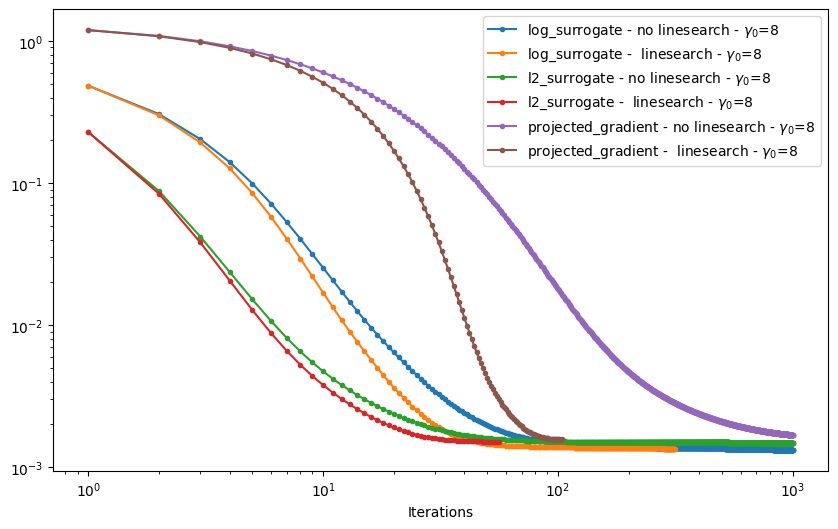

In [16]:
plt.figure(figsize=[10, 6])
# plt.figure(figsize=[15, 10])

for loss, caption in zip(losses, captions):
    iterations = np.arange(len(loss))+1
    if len(iterations)>10:
        plt.plot(iterations, loss-l_infty, ".-", label=caption)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Iterations")
plt.legend()

In [ ]:
for gamma, caption in zip(gammas, captions):
    iterations = np.arange(len(gamma))+1

    plt.plot(iterations, gamma, ".", label=caption)
plt.legend()


In [ ]:

shape_2d = [10, 15]
k = 5
n_poisson = 200
G, P, A, Xtrue, X = create_toy_problem(p = shape_2d[0]*shape_2d[1], k=k, n_poisson=n_poisson)

# X = Xtrue
L = create_laplacian_matrix(*shape_2d)
lambda_L = 20

W1 = np.random.rand(*P.shape)
H1 = np.random.rand(*A.shape)
# H1 = H1/np.sum(H1, axis=0, keepdims=True)
W2 = W1.copy()
H2 = H1.copy()

W3 = W1.copy()
H3 = H1.copy()

H4 = H1.copy()
W4 = W1.copy()

H5 = H1.copy()
W5 = W1.copy()

W0 = W1.copy()
H0 = H1.copy()



def loss(P, A):
    DA = G @ P @ A
    v1 = KL(X, DA) 
    v2 = trace_xtLx(L, A.T)
    return v1 + lambda_L/2 * v2

maxit = 100
force_simplex = False
loss0 = [loss(W0, H0)]

loss1 = [loss(W1, H1)]
loss2 = [loss(W2, H2)]
diff_loss2 = []
loss3 = [loss(W3, H3)]
diff_loss3 = []

loss4 = [loss(W4, H4)]
diff_loss4 = []
loss5 = [loss(W5, H5)]
diff_loss5 = []

# gammH2 = sigmaL
gammH2 = 1e-3
gammH2 = 0.005
gammH2 = 0.25

gammH5 = 1e-3
gammH5 = 0.005
gammH5 = 0.4

gammH3 = sigmaL
# gammH3 = 0.4
gammH3_vec = [gammH3]
d3 = []

gammH4 = sigmaL
# gammH4 = 0.25
gammH4_vec = [gammH4]
d4 = []



for i in range(maxit):
    H0 = multiplicative_step_h(X, G, W0, H0, force_simplex=force_simplex, lambda_L=lambda_L, L=L)
    W0 = multiplicative_step_w(X, G, W0, H0)
    loss0.append(loss(W0, H0))
    
    H1 = multiplicative_step_hq(X, G, W1, H1, force_simplex=force_simplex, lambda_L=lambda_L, L=L)
    W1 = multiplicative_step_w(X, G, W1, H1)
    loss1.append(loss(W1, H1))

    
    H2 = multiplicative_step_hq(X, G, W2, H2, force_simplex=force_simplex, lambda_L=lambda_L, L=L, sigmaL=gammH2)
    diff_loss2.append(loss2[-1]-loss(W2, H2))
    W2 = multiplicative_step_w(X, G, W2, H2)
    loss2.append(loss(W2, H2))

    H3_old = H3.copy()
    H3 = multiplicative_step_hq(X, G, W3, H3, force_simplex=force_simplex, lambda_L=lambda_L, L=L, sigmaL=gammH3)
    d3.append(diff_surrogate(H3_old, H3, L=L, sigmaL=gammH3))
    diff_loss3.append(d3)
    if d3[-1]>0:
        gammH3 = gammH3 / 1.05
    else:
        gammH3 = gammH3 * 1.5
    gammH3_vec.append(gammH3)
    W3 = multiplicative_step_w(X, G, W3, H3)
    loss3.append(loss(W3, H3))
    
    H4_old = H4.copy()
    H4 = multiplicative_step_h(X, G, W4, H4, force_simplex=force_simplex, lambda_L=lambda_L, L=L, sigmaL=gammH4)
    d4.append(diff_surrogate(H4_old, H4, L=L, sigmaL=gammH4, dgkl=True))
    diff_loss4.append(d4)
    if d4[-1]>0:
        gammH4 = gammH4 / 1.05
    else:
        gammH4 = gammH4 * 1.5
    gammH4_vec.append(gammH4)
    W4 = multiplicative_step_w(X, G, W4, H4)
    loss4.append(loss(W4, H4))
    
    H5 = multiplicative_step_hq(X, G, W5, H5, force_simplex=force_simplex, lambda_L=lambda_L, L=L, sigmaL=gammH5)
    diff_loss5.append(loss5[-1]-loss(W5, H5))
    W5 = multiplicative_step_w(X, G, W5, H5)
    loss5.append(loss(W5, H5))
    

In [ ]:
for i in range(10*maxit):
    H2 = multiplicative_step_hq(X, G, W2, H2, force_simplex=force_simplex, lambda_L=lambda_L, L=L, sigmaL=gammH5)
    W2 = multiplicative_step_w(X, G, W2, H2)

l_infty = loss(W2, H2)

In [ ]:
iterations = np.arange(maxit+1)+1
plt.figure(figsize=[15, 10])
plt.plot(iterations, np.array(loss0)-l_infty, "ko-", label="KL surrogate - theoretical step")
plt.plot(iterations, np.array(loss5)-l_infty, "ro-", label="KL surrogate -  manual fixed step")
plt.plot(iterations, np.array(loss4)-l_infty, "go-", label="KL surrogate - adaptive step size")
plt.plot(iterations, np.array(loss1)-l_infty, "kx-", label="L2 surrogate - theoretical step")
plt.plot(iterations, np.array(loss2)-l_infty, "rx-", label="L2 surrogate - manual fixed step")
plt.plot(iterations, np.array(loss3)-l_infty, "gx-", label="L2 surrogate - adaptive step size")
plt.yscale("log")
plt.xscale("log")
plt.legend()


In [ ]:
plt.plot(gammH3_vec, ".-", label="L2 surrogate")
plt.plot(gammH4_vec, ".-", label="DGKL surrogate")
plt.yscale("log")
plt.title("Evolution of the step size")
plt.legend()


In [ ]:
# def f(x, a, b, c):
#     v = x + b
#     return v - np.sqrt( v**2 + 4*a*c) +2*a 
# p = 1
# x = np.arange(-2,2, 0.1)
# a = np.random.rand(p)
# a = 0.5
# b = np.random.rand(p)
# c = np.random.rand(p)
# plt.plot(x, f(x,a,b,c))
# plt.plot(x, np.zeros_like(x))